# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [822]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing  import Imputer
from sklearn.impute import SimpleImputer, MissingIndicator

import warnings
warnings.filterwarnings('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [692]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [693]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
print(feat_info.shape)

(891221, 85)
(85, 4)


In [694]:
azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [695]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [696]:
# copy dataset and convert to pandas data format
azdias_clean = pd.DataFrame(azdias)
feat_info_clean = pd.DataFrame(feat_info)

In [697]:
# remove "[]" from missing_or_unknown string and put it in the authentic list

feat_info_clean['missing_or_unknown'] = feat_info_clean['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',')
feat_info_clean.set_index(['attribute'], inplace=True)
feat_info_clean.head(5)

information_level         type missing_or_unknown
attribute                                                             
AGER_TYP                        person  categorical            [-1, 0]
ALTERSKATEGORIE_GROB            person      ordinal         [-1, 0, 9]
ANREDE_KZ                       person  categorical            [-1, 0]
CJT_GESAMTTYP                   person  categorical                [0]
FINANZ_MINIMALIST               person      ordinal               [-1]

In [698]:
# Identify missing or unknown data values and convert them to NaNs.

for attr in feat_info_clean.index: ## loop through the list of each attribute in feat_info_clean
    
    for x in feat_info_clean.loc[attr]['missing_or_unknown']:  ## loop through the attribute and read the missing_or_unknown value
        
        #if the element list is not empty
        if len(x) > 0:
            # convert the specified value into NaN
            try:
                azdias_clean[attr].replace(int(x), np.nan, inplace=True)
             #the case when the specified value cannot be interpreted as integer
            except:   
                #print(attr, x)
                azdias_clean[attr].replace(x, np.nan, inplace=True)
                print(attr, x)

CAMEO_DEUG_2015 X
CAMEO_DEU_2015 XX
CAMEO_INTL_2015 XX


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

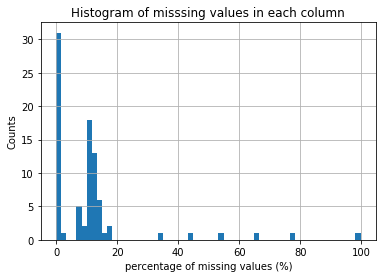

In [699]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# count how many missing values in each column
col_missing = azdias_clean.isnull().sum()  #(by deleting missing value and count it in each column)

col_missing_percentage = col_missing/(azdias.shape[0]) * 100
col_missing_percentage.sort_values(inplace=True) # sorting the values

col_missing_percentage.hist(bins=60)
plt.title("Histogram of misssing values in each column")
plt.xlabel("percentage of missing values (%)")
plt.ylabel("Counts")
plt.show()

In [700]:
# calculate how many columnes have missing values
col_missing_percentage=pd.DataFrame(col_missing_percentage)
col_missing_percentage.columns = ["Percentage"]

number_of_p = 0
for col in col_missing_percentage["Percentage"]:
        if col > 0:
            
            number_of_p = number_of_p+1
    
print("There are {} columns with missing values.".format(number_of_p))
#read the percentage of missing values in each columns
col_missing_percentage.sort_values("Percentage",ascending=False).head(61)

There are 61 columns with missing values.


Percentage
TITEL_KZ                99.757636
AGER_TYP                76.955435
KK_KUNDENTYP            65.596749
KBA05_BAUMAX            53.468668
GEBURTSJAHR             44.020282
ALTER_HH                34.813699
KKK                     17.735668
REGIOTYP                17.735668
W_KEIT_KIND_HH          16.605084
KBA05_ANTG4             14.959701
KBA05_GBZ               14.959701
MOBI_REGIO              14.959701
KBA05_ANTG1             14.959701
KBA05_ANTG2             14.959701
KBA05_ANTG3             14.959701
PLZ8_ANTG4              13.073637
PLZ8_ANTG2              13.073637
PLZ8_ANTG1              13.073637
PLZ8_ANTG3              13.073637
PLZ8_BAUMAX             13.073637
PLZ8_GBZ                13.073637
PLZ8_HHZ                13.073637
SHOPPER_TYP             12.476816
VERS_TYP                12.476816
HEALTH_TYP              12.476816
NATIONALITAET_KZ        12.153551
PRAEGENDE_JUGENDJAHRE   12.136608
KBA13_ANZAHL_PKW        11.871354
ANZ_HAUSHALTE_AKTIV     11.176913
CAMEO_DEU_2015          11.147852
...                           ...
CAMEO_INTL_2015         11.147852
LP_LEBENSPHASE_FEIN     10.954859
RELAT_AB                10.926022
ARBEIT                  10.926022
ORTSGR_KLS9             10.914689
ANZ_HH_TITEL            10.884842
LP_LEBENSPHASE_GROB     10.611509
INNENSTADT              10.518154
EWDICHTE                10.518154
BALLRAUM                10.518154
GEBAEUDETYP_RASTER      10.452514
MIN_GEBAEUDEJAHR        10.451729
WOHNLAGE                10.451729
OST_WEST_KZ             10.451729
GEBAEUDETYP             10.451729
LP_FAMILIE_FEIN          8.728699
LP_FAMILIE_GROB          8.728699
KONSUMNAEHE              8.299737
ANZ_PERSONEN             8.247000
SOHO_KZ                  8.247000
ANZ_TITEL                8.247000
WOHNDAUER_2008           8.247000
HH_EINKOMMEN_SCORE       2.058749
ONLINE_AFFINITAET        0.544646
GFK_URLAUBERTYP          0.544646
LP_STATUS_GROB           0.544646
LP_STATUS_FEIN           0.544646
RETOURTYP_BK_S           0.544646
CJT_GESAMTTYP            0.544646
ALTERSKATEGORIE_GROB     0.323264

[61 rows x 1 columns]

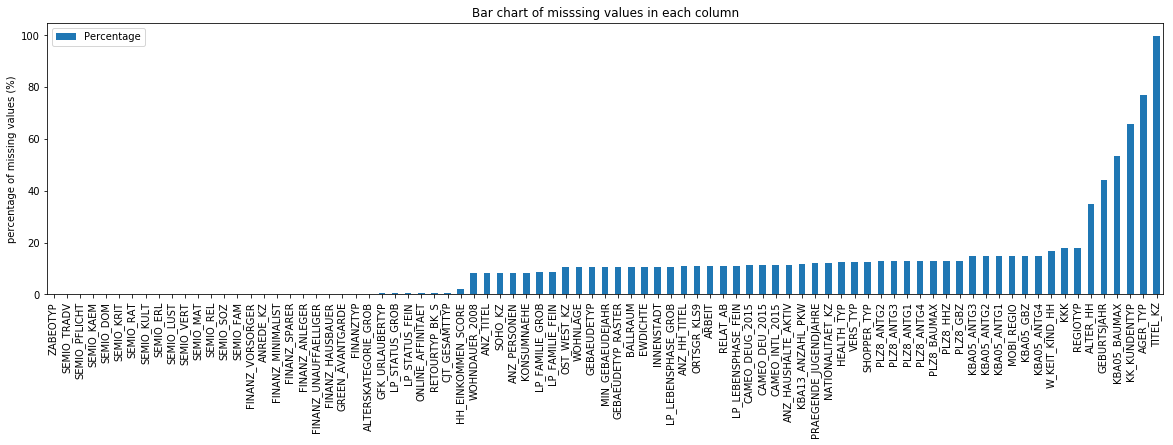

In [756]:
#bar chart of percentage of missing data in each column
col_missing_percentage.plot.bar(figsize=(20,5))
plt.title("Bar chart of misssing values in each column")
plt.ylabel("percentage of missing values (%)")
plt.show()

In [702]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

del_col = col_missing_percentage[col_missing_percentage['Percentage'] > 30].index
print("There are {} columns with missing values greater than 30%.".format(del_col.shape[0]))
print(del_col)
# drop the column with the missing value greater than 30%
azdias_clean.drop(del_col, axis=1, inplace=True)
azdias_clean.shape

There are 6 columns with missing values greater than 30%.
Index(['ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP',
       'TITEL_KZ'],
      dtype='object')


(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

##### Answer: 
Most of the NaNs in each column is less than 30%. So I removed the columns having NaNs more than 40% from azdias dataset. The 6 columns I removed are 'ALTER_HH', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'AGER_TYP','TITEL_KZ'.
       
Patterns of the missing values in the remaining features:
 
- 24 features have no missing values. Most of them are Personality typology.
- The information about people's residential proximity (e.g.the neighbors' family structures) tends to have more missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

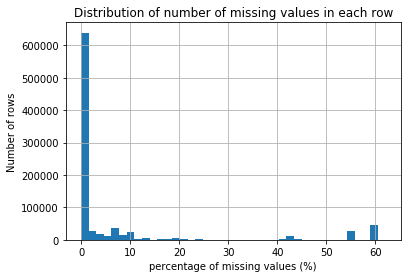

In [703]:
# How much data is missing in each row of the dataset?

# count how many missing values in each row
row_missing = azdias_clean.isnull().sum(axis=1) #(by deleting missing value and count it in each row)
row_missing_percentage = row_missing/(len(azdias_clean.columns)) * 100

row_missing_percentage.hist(bins=40)
plt.title("Distribution of number of missing values in each row")
plt.xlabel("percentage of missing values (%)")
plt.ylabel("Number of rows");

In [704]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

row_missing_few = azdias_clean[row_missing_percentage < 20].reset_index(drop=True)
row_missing_more = azdias_clean[row_missing_percentage >= 20].reset_index(drop=True)
#row_missing_few.head() 
print("Divide the data into two subsets with missing values greater or less than 20%.")
print("- One dataset contains {} rows (missing values < 20%)".format(row_missing_few.shape[0]))
print("- Another dataset contains {} rows (missing values >= 20%)".format(row_missing_more.shape[0]))

Divide the data into two subsets with missing values greater or less than 20%.
- One dataset contains 792287 rows (missing values < 20%)
- Another dataset contains 98934 rows (missing values >= 20%)


To check if a threshold of 20% is a fine choice, Kolmogorov–Smirnov test is used here to test each column against the null hypothesis.  The lower the p-value the more we can assume that the two distributions are different.



In [705]:
from scipy.stats import ks_2samp

def hypothesis_test(df1, df2, cols):
    stats = []
    pvalues = []
    for col in cols:
        counts_main = df1[col].value_counts().sort_index()
        counts_drop = df2[col].value_counts().sort_index()
        try:
            ch = ks_2samp(counts_main, counts_drop)
            stats.append(ch.statistic)
            pvalues.append(ch.pvalue)
        except:
            stats.append(np.nan)
            pvalues.append(np.nan)

    return stats, pvalues

In [706]:
stats, pvalues = hypothesis_test(row_missing_few, row_missing_more, row_missing_few.columns.values)
comp_df = pd.DataFrame(azdias_clean.columns.values, columns=["features"])
comp_df['stats'] = stats
comp_df['pvalues'] = pvalues
comp_df[comp_df['pvalues']<=0.05].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70 entries, 0 to 78
Data columns (total 3 columns):
features    70 non-null object
stats       70 non-null float64
pvalues     70 non-null float64
dtypes: float64(2), object(1)
memory usage: 2.2+ KB


If using 20% missing value as a threshold, 70 features are statistically difference. It is bacause their p-values are less then 5%, and we cannot reject the null hypothesis that the distributions of the two samples are different.

In [707]:
print('columns without missing data')
col_no_missing = col_missing_percentage[col_missing_percentage['Percentage']==0].index
print(col_no_missing)
print('columns with less missing data (<0.545%)')
col_few_missing = col_missing_percentage[(col_missing_percentage['Percentage']>0) & (col_missing_percentage['Percentage']<0.545)].index
print(col_few_missing)

columns without missing data
Index(['ZABEOTYP', 'SEMIO_TRADV', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM',
       'SEMIO_KRIT', 'SEMIO_RAT', 'SEMIO_KULT', 'SEMIO_ERL', 'SEMIO_LUST',
       'SEMIO_VERT', 'SEMIO_MAT', 'SEMIO_REL', 'SEMIO_SOZ', 'SEMIO_FAM',
       'FINANZ_VORSORGER', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'GREEN_AVANTGARDE', 'FINANZTYP'],
      dtype='object')
columns with less missing data (<0.545%)
Index(['ALTERSKATEGORIE_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB',
       'LP_STATUS_FEIN', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
       'CJT_GESAMTTYP'],
      dtype='object')


In [708]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def print_countplot(cols,num):
    '''
    function to compare data in two subsets (few missing vs. more missing)
    '''
    fig, axs = plt.subplots(num,2, figsize=(12, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace =0.5 , wspace=.2)
    axs = axs.ravel()

    for i in range(num):
        sns.countplot(row_missing_few[cols[i]], ax=axs[i*2])
        axs[i*2].set_title('few missing')
        
        sns.countplot(row_missing_more[cols[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('more missing')

In [709]:
print('Distribution of data values on columns with not missing data')
col_no_missing = ['ZABEOTYP', 'SEMIO_TRADV'] 
print_countplot(col_no_missing,len(col_no_missing))

Distribution of data values on columns with not missing data


In [710]:
# find p value"
print(comp_df[comp_df["features"]==col_no_missing[0]])
print(comp_df[comp_df["features"]==col_no_missing[1]])

    features     stats   pvalues
39  ZABEOTYP  0.833333  0.012238
       features     stats   pvalues
35  SEMIO_TRADV  0.857143  0.004171


In [711]:
print('Distribution of data values on columns with less missing data')
col_few_missing = ['ALTERSKATEGORIE_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB'] 
print_countplot(col_few_missing,len(col_few_missing))

Distribution of data values on columns with less missing data


In [712]:
# find p value"
print(comp_df[comp_df["features"]==col_few_missing[0]])
print(comp_df[comp_df["features"]==col_few_missing[1]])
print(comp_df[comp_df["features"]==col_few_missing[2]])

               features  stats   pvalues
0  ALTERSKATEGORIE_GROB    1.0  0.011066
           features     stats   pvalues
10  GFK_URLAUBERTYP  0.916667  0.000021
          features  stats   pvalues
18  LP_STATUS_GROB    0.8  0.036146


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

##### Answers:
- I chose five columns: two columns have no missing value ('ZABEOTYP', 'SEMIO_TRADV'); three columns have few missing values ('ALTERSKATEGORIE_GROB', 'GFK_URLAUBERTYP', 'LP_STATUS_GROB').
- For the columns with no missing values, it appears that both columns have a big difference between few missing data and more missing data in the row. That means those data are special and can not be ignored.
- For the columns with few missing values, ALTERSKATEGORIE_GROB has a little difference between few missing and more missing data, while GFK_URLAUBERTYP and LP_STATUS_GROB show some differences with more data in more_missing data compared to the few missing data. This means that we should pay attension to those data as they are special.
- After I did the statistical analysis using Kolmogorov–Smirnov model, I found all five features are significantly difference between two groups with more missing data and few missing data in each row. Therefore, we should make a note on those data as special.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [713]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [714]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

binary_category = []
multi_category = []

# features which are categorical
feat_category = feat_info[feat_info['type'] == "categorical"]

# loop thorough each categorical features
for attr in feat_category.index:
    try:
  
    # if the categorical fetures is binary (2 categories)
        if azdias_clean.loc[:,attr].nunique() == 2:
            print("binary with {} values              ".format(azdias_clean.loc[:,attr].dtype), attr)
            binary_category.append(attr)    
    # if the categorical fetures is multi-level (more than 2 categories)
        elif azdias_clean.loc[:,attr].nunique() > 2:
            multi_category.append(attr)
        else:
            print("Categorical Something Wrong!")
    except:
        print ("Not in columns anymore")

Not in columns anymore
binary with int64 values               ANREDE_KZ
binary with int64 values               GREEN_AVANTGARDE
binary with float64 values               SOHO_KZ
Not in columns anymore
binary with float64 values               VERS_TYP
Not in columns anymore
binary with object values               OST_WEST_KZ


In [715]:
print(multi_category)
print(binary_category)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [716]:
azdias_clean1 = row_missing_few

In [717]:
# Re-encode categorical variable(s) to be kept in the analysis.

# check the binary features whose values are not numeric
print(azdias_clean1["OST_WEST_KZ"].value_counts())

W    624737
O    167550
Name: OST_WEST_KZ, dtype: int64


In [718]:
# Re-encode categorical variable "OST_WEST_KZ" to numeric values

def make_numeric(x):
    if x == 'O':
        return 0
    if x == 'W':
        return 1
    
azdias_clean1['OST_WEST_KZ'] = azdias_clean1['OST_WEST_KZ'].apply(make_numeric)
azdias_clean1["OST_WEST_KZ"].value_counts()

1    624737
0    167550
Name: OST_WEST_KZ, dtype: int64

In [719]:
# drop multi-level category from dataset
azdias_clean1.drop(multi_category, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Answers:
- Remove all multi-lavel categorical variables: 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'
- Re-encode categorical variable(s): OST_WEST_KZ. Reengineer it to numeric values.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [720]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def get_decade(x):
    if x in (1,2):
        return 1
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    else:
        return 6
    
def get_movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    else:
        return 1
    
# create first new varibale: 'PRAEGENDE_JUGENDJAHRE_DECADE'
azdias_clean1['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_clean1['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
# create second new varibale: 'PRAEGENDE_JUGENDJAHRE_MOV'
azdias_clean1['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias_clean1['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)

# drop original column
azdias_clean1=azdias_clean1.drop('PRAEGENDE_JUGENDJAHRE',axis=1)

In [721]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def wealth(x):
    try:
        return int(x) // 10
    except ValueError:
        return np.nan
    
def life_stage(x):
    try:
        return int(x) % 10
    except ValueError:
        return np.nan

# create first new varibale: 'CAMEO_INTL_2015_WEALTH''
azdias_clean1['CAMEO_INTL_2015_WEALTH'] = azdias_clean1['CAMEO_INTL_2015'].apply(wealth)
# create first new varibale: 'CAMEO_INTL_2015_LIFE_STAGE''
azdias_clean1['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_clean1['CAMEO_INTL_2015'].apply(life_stage)
    
# drop original column
azdias_clean1=azdias_clean1.drop('CAMEO_INTL_2015',axis=1)

In [722]:
feat_mixed = feat_info[feat_info['type'] == "mixed"]
feat_mixed

information_level   type missing_or_unknown
attribute                                                        
LP_LEBENSPHASE_FEIN              person  mixed                [0]
LP_LEBENSPHASE_GROB              person  mixed                [0]
PRAEGENDE_JUGENDJAHRE            person  mixed            [-1, 0]
WOHNLAGE                       building  mixed               [-1]
CAMEO_INTL_2015           microcell_rr4  mixed           [-1, XX]
KBA05_BAUMAX              microcell_rr3  mixed            [-1, 0]
PLZ8_BAUMAX              macrocell_plz8  mixed            [-1, 0]

In [723]:
# re-engineer "WOHNLAGE"
# I engineer a second variable that acts as a rural flag (e.g. 1-5 = not rural, 7-8 = rural)

def rural(x):
    if x in (1,2,3,4,5):
        return 0
    else:
        return 1
    
azdias_clean1['WOHNLAGE'] = azdias_clean1['WOHNLAGE'].apply(rural)

In [724]:
# re-engineer 'PLZ8_BAUMAX'
# The scale is ordinal from 1-4 with size of housing buildings, but 5 indicates business buildings. 
# I replace 5 as a missing value (NaN) from the 'PLZ8_BAUMAX' column

def fillna(x):
    try:
        if x in (1,2,3,4):
            return int(x)
    except ValueError:
        return np.nan
    
azdias_clean1['PLZ8_BAUMAX'] = azdias_clean1['PLZ8_BAUMAX'].apply(fillna)

In [725]:
# drop 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB'
azdias_clean1=azdias_clean1.drop('LP_LEBENSPHASE_FEIN',axis=1)
azdias_clean1=azdias_clean1.drop('LP_LEBENSPHASE_GROB',axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

##### Answers:
###### Remove: 
1) LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB
    - According to data dictionary, these two variables represent personal age level, salary level and household type. Other columns already contain these information)
2) KBA05_BAUMAX
    - This feature has been dropped in Step 1.1.2 because it has too many missing values

##### Keep/Re-engineering:  
1) PRAEGENDE_JUGENDJAHRE
    - Engineer two new features to represent decade and movement

2) CAMEO_INTL_2015
    - Engineer two new features to represent wealth and life stage
3) WOHNLAGE
    - Engineer a second variable to represent rural or non-rural 
4) PLZ8_BAUMAX
    - Drop level-5 values from the column, because it indicates business building, whereas 1-4 indicates the family-home building.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [728]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# remove row that has >20% missing values
#azdias_clean = azdias_clean[row_missing_percentage < 20].reset_index(drop=True)
azdias_clean1.shape
#azdias.shape

(792287, 66)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [735]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    #df_clean = pd.DataFrame(df)
    feat_info1 = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')

    feat_info1['missing_or_unknown'] = feat_info1['missing_or_unknown'].str.replace('[','').str.replace(']','').str.split(',')
    feat_info1.set_index(['attribute'], inplace=True)

    for attr in feat_info1.index: 
    
        for x in feat_info1.loc[attr]['missing_or_unknown']:  
            if len(x) > 0:
                try:
                    df[attr].replace(int(x), np.nan, inplace=True)
                except:   
                    df[attr].replace(x, np.nan, inplace=True)
                
    df_clean = pd.DataFrame(df)
    
    ## remove selected columns and rows
    # drop the same columns as in demographics data (sec 1.1.2)
    df_clean.drop(del_col, axis=1, inplace=True) 
    
    # Delete rows with more than 20% of NaNs
    row_missing = df_clean.isnull().sum(axis=1)
    df_clean = df_clean[row_missing/len(df_clean.columns) < 0.2].reset_index(drop=True)
   
    # select, re-encode, and engineer column values.
    # Categorical content
    
    #Fix binary data
    
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].apply(make_numeric)
    
    # Delete categorical data with more than 2 dimensions
    # We know that the binary columns have 3 entries due to some NaN
    
    # create first new varibale: 'PRAEGENDE_JUGENDJAHRE_DECADE'
    df_clean['PRAEGENDE_JUGENDJAHRE_DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
    # create second new varibale: 'PRAEGENDE_JUGENDJAHRE_MOV'
    df_clean['PRAEGENDE_JUGENDJAHRE_MOV'] = df_clean['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)

    # create first new varibale: 'CAMEO_INTL_2015_WEALTH''
    df_clean['CAMEO_INTL_2015_WEALTH'] = df_clean['CAMEO_INTL_2015'].apply(wealth)
    # create first new varibale: 'CAMEO_INTL_2015_LIFE_STAGE''
    df_clean['CAMEO_INTL_2015_LIFE_STAGE'] = df_clean['CAMEO_INTL_2015'].apply(life_stage)
    
    # engineer 'WOHNLAGE' and 'PLZ8_BAUMAX'
    df_clean['WOHNLAGE'] = df_clean['WOHNLAGE'].apply(rural)
    df_clean['PLZ8_BAUMAX'] = df_clean['PLZ8_BAUMAX'].apply(fillna)
    
    # drop original column
    df_clean.drop(multi_category, axis=1, inplace=True)
    df_clean.drop('PRAEGENDE_JUGENDJAHRE',axis=1, inplace=True)
    df_clean.drop('CAMEO_INTL_2015',axis=1, inplace=True)
    
    # drop two columns of mixed-type features
    df_clean.drop('LP_LEBENSPHASE_FEIN',axis=1, inplace=True)
    df_clean.drop('LP_LEBENSPHASE_GROB',axis=1, inplace=True)
    
    # Return the cleaned dataframe.

    return df_clean

In [737]:
# double check to see if input azdias into the function will return the same shape
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

clean_data(azdias).shape

(792287, 66)

In [795]:
print(azdias.shape)
print(azdias_clean1.shape)

(891221, 85)
(792287, 66)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [738]:
# consider the process of removing all columns or rows which include NaN in them
print("{}  columns include NaN".format(azdias_clean1.dropna(axis="columns").shape[1]))
print("{} rows include NaN".format(azdias_clean1.dropna(axis="rows").shape[0]))

32  columns include NaN
546342 rows include NaN


In [802]:
# first removes all data points with missing values before feature scaling
azdias_clean2 = azdias_clean1.dropna(axis="columns")
azdias_clean2.shape

(792287, 32)

Next, I compare three scaling functions in scikit-learn to see if there is any major differences to the transformed dataset when they are applied. 

In [805]:
def compare_scalers(data, features: list):
    """
    compares three different scaling functions from sklearn
    INPUT: a list of features to be transformed under the different scalers
    Returns: plots of the unscaled data, and the transformed data
    """
    scaler1 = StandardScaler()
    standard_scaled_data = pd.DataFrame(scaler1.fit_transform(data), columns=list(data))
    scaler2 = RobustScaler()
    robust_scaled_data = pd.DataFrame(scaler2.fit_transform(data), columns=list(data))
    scaler3 = MinMaxScaler()
    minmax_scaled_data = pd.DataFrame(scaler3.fit_transform(data), columns=list(data))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 5))

    for feature in features:
        ax1.set_title('Before Scaling')
        sns.kdeplot(data[feature], ax=ax1)
        ax2.set_title('After Standard Scaler')
        sns.kdeplot(standard_scaled_data[feature], ax=ax2)
        ax3.set_title('After MinMax Scaler')
        sns.kdeplot(minmax_scaled_data[feature], ax=ax3)
        ax4.set_title('After Robust Scaler')
        sns.kdeplot(robust_scaled_data[feature], ax=ax4)
    plt.show()

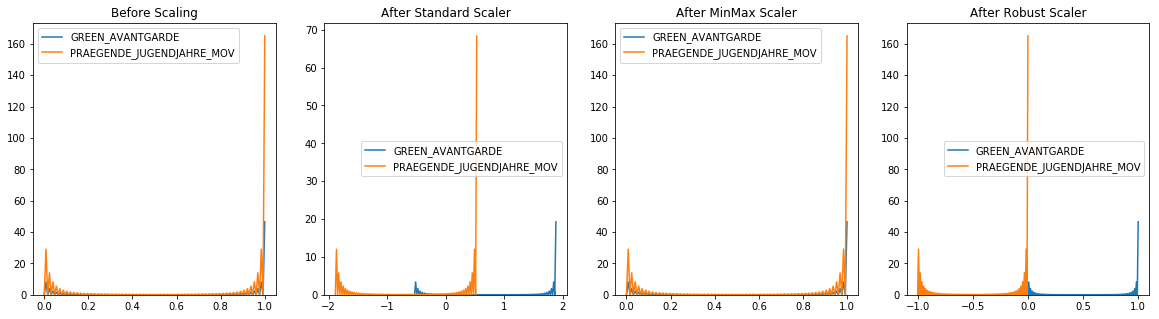

In [806]:
np.random.seed(123)
feature_compared = list(np.random.choice(list(azdias_clean2), size=2, replace=False))
compare_scalers(azdias_clean2, feature_compared)

There are no major qualitative difference in the data after applying these three scalers. So choose anyone of them should be okay. Because we have a large amount of data, we can assume a normal distribution on the data (from the Central Limit Theorem). Based on this assumption, we can go ahead and use the Standard Scaler for feature scaling.

In [886]:
## Try to fill NaNs with the mean of values in the same column using Imputer
# Apply feature scaling to the general population demographics data.
Imputer = SimpleImputer(strategy= "mean")
scaler = StandardScaler()
azdias_clean_scaled= scaler.fit_transform(Imputer.fit_transform(azdias_clean1))
azdias_clean_scaled = pd.DataFrame(azdias_clean_scaled, columns=list(azdias_clean1))
azdias_clean_scaled.describe()

ALTERSKATEGORIE_GROB     ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count          7.922870e+05  7.922870e+05       7.922870e+05   7.922870e+05   
mean           3.726561e-15 -2.260948e-15       7.590093e-15  -2.683807e-15   
std            1.000001e+00  1.000001e+00       1.000001e+00   1.000001e+00   
min           -1.766262e+00 -1.043729e+00      -1.492816e+00  -1.154259e+00   
25%           -7.827599e-01 -1.043729e+00      -7.669478e-01  -1.154259e+00   
50%            2.007420e-01  9.581032e-01      -4.107917e-02   1.921875e-01   
75%            1.184244e+00  9.581032e-01       6.847894e-01   8.654109e-01   
max            1.184244e+00  9.581032e-01       1.410658e+00   1.538634e+00   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count      7.922870e+05    7.922870e+05           7.922870e+05   
mean      -5.811306e-15   -2.279105e-14           5.614044e-15   
std        1.000001e+00    1.000001e+00           1.000001e+00   
min       -1.768435e+00   -1.249434e+00          -1.180665e+00   
25%       -1.042098e+00   -1.249434e+00          -1.180665e+00   
50%        4.105766e-01    1.086148e-01          -4.650897e-01   
75%        1.136914e+00    7.876393e-01           9.660599e-01   
max        1.136914e+00    1.466664e+00           1.681635e+00   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE    HEALTH_TYP  \
count      7.922870e+05      7.922870e+05  7.922870e+05   
mean       5.724242e-15      3.636496e-14  4.059934e-16   
std        1.000001e+00      1.000001e+00  1.000001e+00   
min       -1.511484e+00     -5.310496e-01 -1.627422e+00   
25%       -7.998623e-01     -5.310496e-01 -2.720636e-01   
50%       -8.824056e-02     -5.310496e-01 -2.720636e-01   
75%        6.233811e-01     -5.310496e-01  1.083295e+00   
max        1.335003e+00      1.883063e+00  1.083295e+00   

                  ...               PLZ8_BAUMAX      PLZ8_HHZ      PLZ8_GBZ  \
count             ...              7.922870e+05  7.922870e+05  7.922870e+05   
mean              ...             -1.484196e-14 -1.028502e-15  3.505387e-14   
std               ...              1.000001e+00  1.000001e+00  1.000001e+00   
min               ...             -5.751158e-01 -2.713835e+00 -2.166583e+00   
25%               ...             -5.751158e-01 -6.365684e-01 -3.466569e-01   
50%               ...             -5.751158e-01  4.612458e-16 -3.466569e-01   
75%               ...              5.058147e-16  4.020647e-01  5.633063e-01   
max               ...              2.841865e+00  1.440698e+00  1.473269e+00   

             ARBEIT   ORTSGR_KLS9      RELAT_AB  PRAEGENDE_JUGENDJAHRE_DECADE  \
count  7.922870e+05  7.922870e+05  7.922870e+05                  7.922870e+05   
mean  -1.913302e-14  3.619215e-15 -5.444193e-15                 -3.587216e-15   
std    1.000001e+00  1.000001e+00  1.000001e+00                  1.000001e+00   
min   -2.178351e+00 -1.871033e+00 -1.528569e+00                 -2.313235e+00   
25%   -1.698266e-01 -5.649193e-01 -7.914338e-01                 -9.474986e-01   
50%   -1.698266e-01 -1.295482e-01 -5.429828e-02                  4.182381e-01   
75%    8.344356e-01  7.411941e-01  6.828373e-01                  1.101106e+00   
max    1.838698e+00  1.611936e+00  1.419973e+00                  1.101106e+00   

       PRAEGENDE_JUGENDJAHRE_MOV  CAMEO_INTL_2015_WEALTH  \
count               7.922870e+05            7.922870e+05   
mean               -3.636487e-14            4.456302e-15   
std                 1.000001e+00            1.000001e+00   
min                -1.883063e+00           -1.550740e+00   
25%                 5.310496e-01           -8.661862e-01   
50%                 5.310496e-01            5.029215e-01   
75%                 5.310496e-01            1.187475e+00   
max                 5.310496e-01            1.187475e+00   

       CAMEO_INTL_2015_LIFE_STAGE  
count                7.922870e+05  
mean                 4.837544e-15  
std                  1.000001e+00  
min                 -1.263906e+00  
25%  

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- I imputed the missing values using Imputer package that replaces the missing value with the mean of the column. 
- To bring the data to same scale for comparison, I standardized the data using StandardScaler package

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [840]:
# Apply PCA to the data.
def do_pca(X, n_components):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           X - Scaled data

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''    
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained Variance (%)")
    plt.title('Explained Variance Per Principal Component')

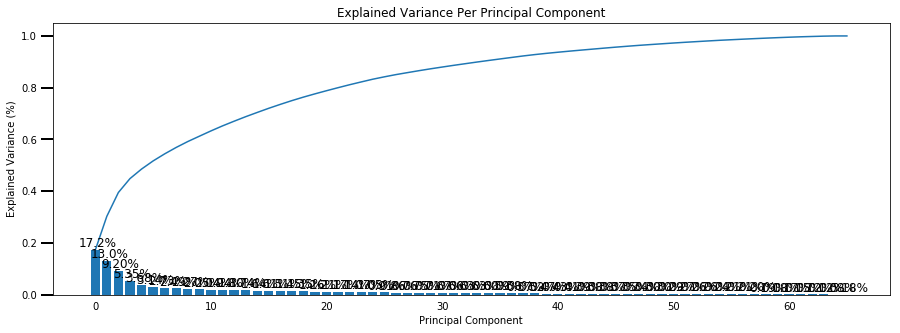

In [841]:
# Investigate the variance accounted for by each principal component.

pca, X_pca = do_pca(azdias_clean_scaled, azdias_clean1.shape[1])
scree_plot(pca)

In [844]:
min_n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>0.85)[0]+1)

print('We retain {} components because they explain 85% variance in the data'.format(min_n_components));

We retain 27 components because they explain 85% variance in the data


In [843]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca27, X_pca = do_pca(azdias_clean_scaled, min_n_components)
scree_plot(pca27)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

##### Answer:
The scree plot above shows that after using 27 components, the variance explained percentage starts to level off and converge towards 85%. That seems to be a good number of components to retain.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [845]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(pca, cols, component):
    comp =  pd.DataFrame({'attribute': cols, 'weight': pca.components_[component], 'weight_abs': np.abs(pca.components_[component])})
    return comp.sort_values(by=['weight_abs'], ascending=False)

In [850]:
comp_0 = map_weights(pca27, azdias_clean1.columns, 0)
comp_0.head(6)

attribute    weight  weight_abs
48   MOBI_REGIO -0.239300    0.239300
54   PLZ8_ANTG3  0.230461    0.230461
52   PLZ8_ANTG1 -0.228055    0.228055
55   PLZ8_ANTG4  0.222710    0.222710
38  KBA05_ANTG1 -0.222335    0.222335
42    KBA05_GBZ -0.215429    0.215429

In [853]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_1 = map_weights(pca27, azdias_clean1.columns, 1)
comp_1.head(6)

attribute    weight  weight_abs
0           ALTERSKATEGORIE_GROB  0.269870    0.269870
13                     SEMIO_REL -0.264711    0.264711
62  PRAEGENDE_JUGENDJAHRE_DECADE -0.251619    0.251619
3                  FINANZ_SPARER -0.249925    0.249925
4               FINANZ_VORSORGER  0.243069    0.243069
23                 SEMIO_PFLICHT -0.239081    0.239081

In [854]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

comp_2 = map_weights(pca27, azdias_clean1.columns, 2)
comp_2.head(6)

attribute    weight  weight_abs
1    ANREDE_KZ -0.369262    0.369262
15  SEMIO_VERT  0.346859    0.346859
22  SEMIO_KAEM -0.337867    0.337867
21   SEMIO_DOM -0.313193    0.313193
20  SEMIO_KRIT -0.276545    0.276545
11   SEMIO_SOZ  0.263240    0.263240

In [852]:
comp_3 = map_weights(pca27, azdias_clean1.columns, 3)
comp_3.head(6)

attribute    weight  weight_abs
8            GREEN_AVANTGARDE  0.392634    0.392634
63  PRAEGENDE_JUGENDJAHRE_MOV -0.392634    0.392634
44                   EWDICHTE  0.254906    0.254906
60                ORTSGR_KLS9  0.249385    0.249385
29         HH_EINKOMMEN_SCORE -0.248727    0.248727
47                        KKK -0.245630    0.245630

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

##### Answers:

Here are the interpretation of the first three components as requested above:

##### 1st Component (0):  mainly about the residential informaton (PLZ8 and RR3 region).

+	MOBI_REGIO	: Movement patterns
+	PLZ8_ANTG3	: Number of 6-10 family houses in the PLZ8 region
+	PLZ8_ANTG1	: Number of 1-2 family houses in the PLZ8 region
+	PLZ8_ANTG4	: Number of 10+ family houses in the PLZ8 region
+	KBA05_ANTG1	 :  Number of 1-2 family houses in the microcell
+	KBA05_GBZ	: Number of buildings in the microcell

##### 2nd Component (1):  mainly about the personality and finacial informaton .
+ ALTERSKATEGORIE_GROB	: Estimated age based on given name analysis
+	SEMIO_REL	: Personality typology,religious
+	PRAEGENDE_JUGENDJAHRE_DECADE : Dominating movement of person's youth 
+  FINANZ_SPARER	: Financial typology, money-saver
+ FINANZ_VORSORGER	: Financial typology, be prepared
+	SEMIO_PFLICHT	: Personality typology, dutiful


##### 3rd Component (2):  similar to 2nd component, mainly about the personality informaton.

+	ANREDE_KZ	: Gender
+	SEMIO_VERT	:Personality typology, dreamful
+	SEMIO_KAEM	:Personality typology, combative attitude
+	SEMIO_DOM	:Personality typology, dominant-minded
+	SEMIO_KRIT	:Personality typology, critical-minded
+	SEMIO_SOZ	:Personality typology, socially-minded


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [855]:
# Over a number of different cluster counts...

scores = []

#test to determine k
for k in range(1,30,2):

    # run k-means clustering on the data
    kmeans = KMeans(k, random_state=42)
    model = kmeans.fit(X_pca)
    
    # compute the average within-cluster distances.
    score = np.abs(kmeans.score(X_pca)) 
    scores.append(score)  

    print("Checked = {}, Score = {}".format(k,score))

Checked = 1, Score = 44477259.928331405
Checked = 3, Score = 34516998.81168474
Checked = 5, Score = 30851277.234958615
Checked = 7, Score = 28560250.135568205
Checked = 9, Score = 26993102.399910398
Checked = 11, Score = 25880614.603622563
Checked = 13, Score = 24902462.750298504
Checked = 15, Score = 24288438.116340596
Checked = 17, Score = 23449273.6799667
Checked = 19, Score = 22947262.121269703
Checked = 21, Score = 22319074.29461222
Checked = 23, Score = 22068530.484402765
Checked = 25, Score = 21488949.81947337
Checked = 27, Score = 21157879.404987782
Checked = 29, Score = 20884679.982670683


In [856]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(np.arange(1, 30, 2), scores, linestyle="--", marker='o', color='b')
plt.title("Number of Clusters vs Average Distance to Cluster Centers")
plt.xlabel("number of clusters, k")
plt.ylabel("average distance");

In [857]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# instantiate the kmean object(k=10)
kmeans10= KMeans(10, random_state=42)

# fit the kmeans model with X_pca (THIS WOULD BE USED LATER)
# and also get the clustering result labels

demo_model = kmeans10.fit(X_pca)
demo_predict = demo_model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I visualized each k (1 to 29)'s score, which is a very time consuming task. I have seen the marginal drop in distance is diminishing at around 10 cluster. So I decided to move forward with 10 clusters. 

By applying k-means clustering to the demographic data, I classified each people and toggled 1 of 10 labels. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [858]:
# Load in the customer demographics data.
cust =  pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [862]:
# clean the customer demographics data.
cust_clean = clean_data(cust)
cust_clean.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0          1                  5              1   
1                   4.0          2                  5              1   
2                   4.0          1                  5              1   
3                   3.0          1                  3              1   
4                   3.0          1                  5              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 5               1                      2                 2   
1                 5               1                      4                 4   
2                 5               2                      1                 2   
3                 4               4                      5                 2   
4                 5               1                      2                 3   

   GREEN_AVANTGARDE  HEALTH_TYP             ...              PLZ8_BAUMAX  \
0                 1         1.0             ...                      1.0   
1                 1         2.0             ...                      3.0   
2                 0         2.0             ...                      1.0   
3                 0         3.0             ...                      2.0   
4                 1         3.0             ...                      1.0   

   PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  \
0       5.0       5.0     1.0          2.0       1.0   
1       3.0       2.0     3.0          5.0       3.0   
2       3.0       4.0     1.0          3.0       1.0   
3       3.0       3.0     3.0          5.0       1.0   
4       5.0       5.0     3.0          7.0       5.0   

   PRAEGENDE_JUGENDJAHRE_DECADE  PRAEGENDE_JUGENDJAHRE_MOV  \
0                             2                          0   
1                             2                          0   
2                             1                          1   
3                             4                          1   
4                             2                          0   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LIFE_STAGE  
0                     1.0                         3.0  
1                     3.0                         4.0  
2                     2.0                         4.0  
3                     4.0                         1.0  
4                     3.0                         4.0  

[5 rows x 66 columns]

In [860]:
print("shape of customers' data before cleaning :",cust.shape)
print("shape of customers' data after cleaning :",cust_clean.shape)
print("shape of demographic data after cleaning :",azdias_clean1.shape)

shape of customers' data before cleaning : (191652, 85)
shape of customers' data after cleaning : (140898, 66)
shape of demographic data after cleaning : (792287, 66)


In [861]:
# compare the number of column between demographic data and feature data
azdias_clean1.columns[~azdias_clean1.columns.isin(cust_clean.columns)]

Index([], dtype='object')

customer data and demographic data have the same numbers of feature

In [898]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Standardize or Normalize

cust_clean_scaled = scaler.transform(Imputer.fit_transform(cust_clean))
cust_clean_scaled = pd.DataFrame(cust_clean_scaled, columns=list(cust_clean))

# PCA
cust_clean_pca = pd.DataFrame(pca27.transform(cust_clean_scaled))

# predict (use kmean to predict pca data)
cust_clean_predict = kmeans10.predict(cust_clean_pca);

In [895]:
# check mean is not so far from 0 as well as std not from 1
cust_clean_scaled.describe()

ALTERSKATEGORIE_GROB      ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count         140898.000000  140898.000000      140898.000000  140898.000000   
mean               0.681261      -0.381936           0.877500      -0.865438   
std                0.716151       0.941719           0.738719       0.560013   
min               -1.766262      -1.043729          -1.492816      -1.154259   
25%                0.200742      -1.043729           0.684789      -1.154259   
50%                1.184244      -1.043729           1.410658      -1.154259   
75%                1.184244       0.958103           1.410658      -0.481036   
max                1.184244       0.958103           1.410658       1.538634   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count     140898.000000   140898.000000          140898.000000   
mean           0.821265       -0.841368              -0.565983   
std            0.612587        0.680130               0.696994   
min           -1.768435       -1.249434              -1.180665   
25%            0.410577       -1.249434              -1.180665   
50%            1.136914       -1.249434              -0.465090   
75%            1.136914       -0.570410              -0.465090   
max            1.136914        1.466664               1.681635   

       FINANZ_HAUSBAUER  GREEN_AVANTGARDE     HEALTH_TYP  \
count     140898.000000     140898.000000  140898.000000   
mean          -0.278063          0.672340      -0.321213   
std            0.936738          1.207055       1.038760   
min           -1.511484         -0.531050      -1.627422   
25%           -0.799862         -0.531050      -1.627422   
50%           -0.799862         -0.531050      -0.272064   
75%            0.623381          1.883063       1.083295   
max            1.335003          1.883063       1.083295   

                  ...                PLZ8_BAUMAX       PLZ8_HHZ  \
count             ...              140898.000000  140898.000000   
mean              ...                  -0.250912       0.022829   
std               ...                   0.774489       0.962522   
min               ...                  -0.575116      -2.713835   
25%               ...                  -0.575116      -0.636568   
50%               ...                  -0.575116       0.022829   
75%               ...                  -0.575116       0.402065   
max               ...                   2.841865       1.440698   

            PLZ8_GBZ         ARBEIT    ORTSGR_KLS9       RELAT_AB  \
count  140898.000000  140898.000000  140898.000000  140898.000000   
mean        0.219416      -0.346225      -0.077593      -0.129467   
std         0.910908       1.011543       0.938248       1.045081   
min        -2.166583      -2.178351      -1.871033      -1.528569   
25%        -0.346657      -1.174089      -0.564919      -0.791434   
50%         0.563306      -0.169827      -0.129548      -0.054298   
75%         0.563306       0.834436       0.741194       0.682837   
max         1.473269       1.838698       1.611936       1.419973   

       PRAEGENDE_JUGENDJAHRE_DECADE  PRAEGENDE_JUGENDJAHRE_MOV  \
count                 140898.000000              140898.000000   
mean                      -1.008483                  -0.672340   
std                        0.934719                   1.207055   
min                       -2.313235                  -1.883063   
25%                       -1.630367                  -1.883063   
50%                       -0.947499                   0.531050   
75%                       -0.264630                   0.531050   
max                        1.101106                   0.531050   

       CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LIFE_STAGE  
count           140898.000000               140898.000000  
mean                -0.456793                    0.334868  
std                  0.960761                    0.903421  
min                 -1.550740                   -1.263906  
25%                 -1.550740

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

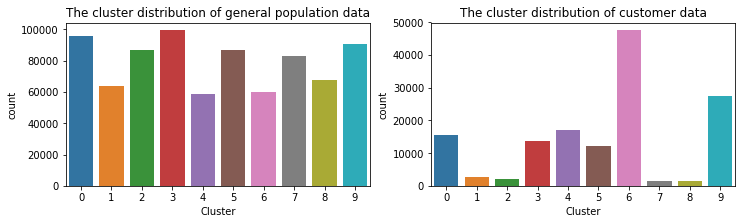

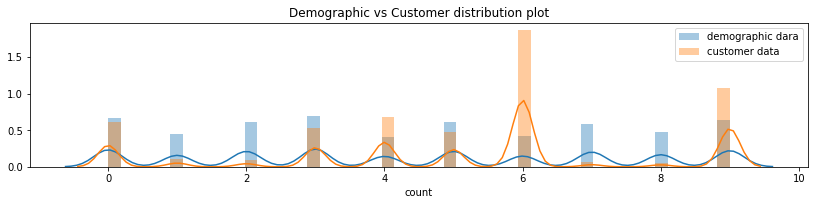

In [899]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.figure(1, figsize=(12, 3))
plt.subplot(121)
sns.countplot(demo_predict)
plt.xlabel('Cluster')
plt.title('The cluster distribution of general population data')
plt.subplot(122)
sns.countplot(cust_clean_predict)
plt.xlabel('Cluster')
plt.title('The cluster distribution of customer data')
plt.show()


ax = plt.figure().add_axes([0,0,1.8,0.5], title='Demographic vs Customer distribution plot')

sns.distplot(demo_predict, label='demographic dara',ax=ax)
sns.distplot(cust_clean_predict, label='customer data', ax=ax)
plt.xlabel('count')
ax.legend();

In [936]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# calculate the proportion of customer data from in each cluster 
prop_cust = pd.DataFrame(cust_clean_predict,columns=['Cluster']).reset_index().groupby('Cluster').count()/cust_clean_predict.shape[0]*100
# calculate the proportion of general population data in each cluster 
prop_pop = pd.DataFrame(demo_predict,columns=['Cluster']).reset_index().groupby('Cluster').count()/demo_predict.shape[0]*100
diff = prop_cust - prop_pop

diff.rename_axis({'index':'Difference'}, axis=1, inplace=True)
prop_cust.rename_axis({'index':'Prop_customer'}, axis=1, inplace=True)
prop_pop.rename_axis({'index':'Prop_population'}, axis=1, inplace=True)
diff = diff.join(prop_cust).join(prop_pop).sort_values('Difference',ascending=True)

diff

Difference  Prop_customer  Prop_population
Cluster                                            
2         -9.414770       1.559284        10.974054
7         -9.410015       1.070278        10.480293
8         -7.523974       0.980142         8.504115
1         -6.162384       1.897827         8.060211
3         -2.891186       9.646695        12.537881
5         -2.362393       8.583514        10.945907
0         -1.148272      10.919956        12.068228
4          4.805568      12.199605         7.394038
9          7.977506      19.444563        11.467057
6         26.129919      33.698136         7.568217

In [927]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print("overrepresented clusters")
#overrepresented Cluster 6 (11.3 %)
c6 = pd.DataFrame()
c6['Component'] = list(range(0,27))
c6['Center'] = list(kmeans10.cluster_centers_[6])
print("Cluster 6")
print(c6.sort_values('Center',ascending=False).head(6))

# overrepresented Cluster 9 (7.98 %)
c9 = pd.DataFrame()
c9['Component'] = list(range(0,27))
c9['Center'] = list(kmeans10.cluster_centers_[9])
print("Cluster 9")
print(c9.sort_values('Center',ascending=False).head(6))

overrepresented clusters
Cluster 6
    Component    Center
2           2  2.771353
3           3  2.449874
14         14  0.429648
1           1  0.259435
4           4  0.218183
10         10  0.149909
Cluster 9
    Component    Center
2           2  1.852064
6           6  0.237938
9           9  0.236357
12         12  0.157276
18         18  0.153709
15         15  0.135918


In [928]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print("underrepresented clusters")
#underrepresented Cluster 2 (-9.41 %)
c2 = pd.DataFrame()
c2['Component'] = list(range(0,27))
c2['Center'] = list(kmeans10.cluster_centers_[2])
print("Cluster 2")
print(c2.sort_values('Center',ascending=False).head(6))

#underrepresented Cluster 7 (-9.41 %)
c7 = pd.DataFrame()
c7['Component'] = list(range(0,27))
c7['Center'] = list(kmeans10.cluster_centers_[7])
print("Cluster 7")
print(c7.sort_values('Center',ascending=False).head(6))

underrepresented clusters
Cluster 2
    Component    Center
8           8  0.332391
23         23  0.219611
18         18  0.097258
5           5  0.064555
11         11  0.058837
15         15  0.058550
Cluster 7
    Component    Center
0           0  4.433777
8           8  0.448604
3           3  0.320134
9           9  0.117444
14         14  0.116017
23         23  0.107187


In [941]:
# find the weight in each component
map_weights(pca27, azdias_clean1.columns, 6).head(6)

attribute    weight  weight_abs
47          KKK  0.396771    0.396771
50     REGIOTYP  0.392420    0.392420
39  KBA05_ANTG2 -0.252874    0.252874
14    SEMIO_MAT -0.252041    0.252041
26     VERS_TYP  0.217982    0.217982
41  KBA05_ANTG4  0.215403    0.215403

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

#### Conclusion: 
The proportion of data in cluster 6 and 9 is significantly higher in the customer data, while the propotion of data in cluster 2 and 7 is significantly lower in the customer data, comparing to the demographic/population data. 

###### Over-represented clusters: (Future target customers)
*Cluster-6* : This group is over-representative in our customer datasbase (33.7%) compared to the general population (7.6%). Most of people in this group are male. This group tends to have less dreamful and socially-mindedand. They have more combative attitude, dominant-minded, and critical-minded. (compnent 2). Most of people in this group have membersship of green avantgarde in environmental sustainability. They also tend to have dominating movement of person's youth. They tend to have higher density of households per square kilometer (component 3).

*Cluster-9* : Meanwhile, they have lower or average purchasing power in RR1 region. They are most likely lower middle class, tranditional worker or in marginal groups. They have lower share of 3-5 family homes. (component 6)

###### Under-represented clusters: (Not our future target customers)
*Cluster-2* : This group is under-representative in our customer datasbase (1.56%) compared to the general population (10.97%). Their insurance Insurance typology tend to be social-safety driven. Their health typology tend to be classification not possible or critical reseraved. They have less materialistic and rational personality (component 8). Their insurance typology tend to have more individualistic-accepting risks. They are likely to be conservative low-returners or determined minimal-Returners. They have less sensual-minded personality (component 23).

*Cluster-7* : People in this group have high movement patterns. They have higher or average share of 6-10 family homes, lower share of 1-2 family homes, but high share of 10+ family homes in PLZ8 region. (component 0)


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.